In [1]:
!pip install pyogrio==0.7.2 geopandas==0.14.3 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 38.8 MB/s eta 0:00:00


In [2]:
%load_ext autoreload
%autoreload 2

import sys, os
from IPython.core.magic import register_cell_magic
from glob import glob
import numpy as np
from google.colab import drive
import ee
import geemap.foliumap as geemap
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import pyproj
import pyarrow

gpd.options.io_engine = "pyogrio"
os.environ["PYOGRIO_USE_ARROW"] = "1"
pd.options.display.float_format = '{:.0f}'.format

In [3]:
ee.Authenticate()
ee.Initialize(project="215656163750")
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')
import utils, explore

@register_cell_magic
def skip(line, cell):
    return

path = "/content/drive/MyDrive/CAFO_data/Europe/"

Mounted at /content/drive


In [4]:
df = pd.read_csv(f"{path}F6_1_Total Information on Installations.csv",\
                 low_memory=False)

# Select the farms and rename the ID column
df = df[df['IEDActivityName'].str.contains('Intensive rearing')].\
        rename(columns={"InstallationInspireID": "FarmID"})

# There can be multiple records of the same farm performing the same
# activity. These have different values for columns related to features
# and permitting. These seem to be something to do with reconsidering
# the permit and perhaps granting exemptions, rather than with distinct
# facilities, so it seems OK to drop these duplicates.

# EXAMPLE:
#display(cafos[cafos["FarmID"] == "AT.CAED/9008391271161.INSTALLATION"])
df.drop_duplicates(subset=["FarmID", "IEDActivityName"], inplace=True)

cafos = gpd.GeoDataFrame(df, geometry=\
                       gpd.points_from_xy(df["Longitude"], df["Latitude"],\
                                          crs="EPSG:4326"))

cafos = cafos.drop(columns=["Longitude", "Latitude",\
                        "installationName",\
                        "installationNameConfidentialityReason",\
                        "addressConfidentialityReason",\
                        "IEDActivityCode",\
                        "CityofFacility", "siteVisitNumber", "relevantChapter",\
                        "permitGranted", "permitReconsidered", "permitUpdated",\
                        "permitURL", "featureType", "featureValue"])

In [5]:
# Basic info

print(f"Total facilities: {len(cafos)}")
print(f"Valid geometries: {cafos['geometry'].is_valid.value_counts().loc[True]}")

print("\n --", cafos["IEDActivityName"].value_counts())
print("\n --", cafos["InstallationStatus"].value_counts())

Total facilities: 23512
Valid geometries: 23512

 -- IEDActivityName
Intensive rearing of poultry with more than 40,000 places for poultry                     11532
Intensive rearing of pigs with more than 2,000 places for production pigs (over 30 kg)     9314
Intensive rearing of pigs with more than 750 places for sows                               2666
Name: count, dtype: int64

 -- InstallationStatus
functional        22269
notRegulated        592
disused             408
decommissioned      243
Name: count, dtype: int64


In [6]:
# Translate the very long names into more manageable ones

activity_dict = {"Intensive rearing of poultry with more than 40,000 places for poultry":\
                 "Poultry, 40000",\
                 "Intensive rearing of pigs with more than 2,000 places for production pigs (over 30 kg)":\
                 "Pigs, 2000",\
                 "Intensive rearing of pigs with more than 750 places for sows":\
                 "Sows, 750"}
cafos["Description"] = ""
for old, new in activity_dict.items():
  cafos.loc[cafos['IEDActivityName'] == old, ["Description"]] = new

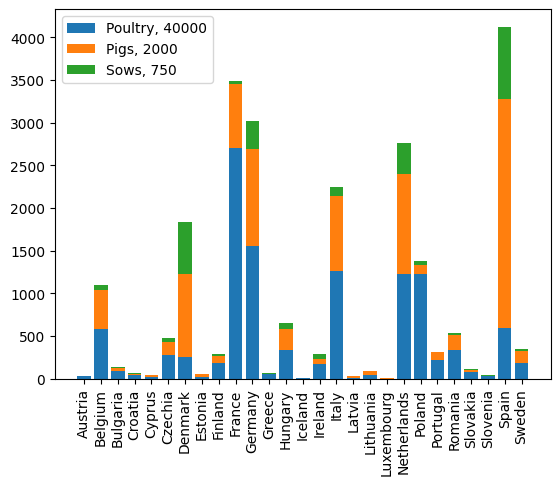

In [7]:
# Facilities by country

# Some of these countries don't report any pig facilities; need to
# account for that
all_countries = cafos[cafos["Description"] == "Poultry, 40000"]\
                     ["countryName"].unique()

# For stacking bar charts
bottom = np.zeros(len(all_countries))

for item in cafos["Description"].unique():
  to_plot = cafos[cafos["Description"] == item]
  to_plot = to_plot["countryName"].value_counts()

  # Add zeros for countries not reporting any facilities
  if "Poultry" not in item:
    zero_countries = [c for c in all_countries if c not in to_plot.index]
    for country in zero_countries:
      to_plot.loc[country] = 0

  to_plot = to_plot.sort_index()
  x = to_plot.index
  height = to_plot.values
  plt.bar(x, height, bottom=bottom, label=item)
  bottom += height
  plt.legend()
  plt.xticks(rotation=90)


## Select a country and process its data

In [8]:
%%skip
# European countries classified as middle-income for 2024-2025
# blogs.worldbank.org/en/opendata/world-bank-country-classifications-by-income-level-for-2024-2025
# No middle-income countries are in the farms dataset

df = pd.read_excel(f"{path}CLASS.xlsx", sheet_name=0)
df = df[df['Region'] == "Europe & Central Asia"]
df = df[df["Income group"].isin(["Upper middle income", "Lower middle income", "Not Classified"])]

In [9]:
# Well, let's see what large-scale farms look like in a few eastern countries
# then. I started with Lithuania, Slovakia, and Bulgaria, which have relatively
# small numbers of buildings. Looking at samples of their farms, I thought they
# looked a bit old-school and maybe not so representative of expansion of IFAP
# in LMICs. So now I'm looking at Hungary and Romania instead. Stenhouse (2008)
# named these countries plus Poland as having the fastest-growing poultry
# sectors in Europe, but Poland has too many buildings so I'm leaving it out.

min_building_size = 200

code = "ROU"
name = "Romania"
crs = "EPSG:3844"

# CRSs for other countries
#"HUN": "EPSG:23700"
#"ROU": "EPSG:3844"
#"POL": "EPSG:2180"
#"LTU": "EPSG:3346"
#"SVK": "EPSG:8352"
#"BGR": "EPSG:7801"

print(f"There are {len(cafos[cafos['countryName'] == name])} farms in {name}")

There are 531 farms in Romania


In [10]:
%%skip

borders = gpd.read_file(f'{path}shapefiles/ne_10m_admin_0_countries.shp')

border = borders[borders['SOV_A3'].str.match(code)]
geom = geemap.geopandas_to_ee(border[['geometry']])

buildings = (
    ee.FeatureCollection(f"projects/sat-io/open-datasets/VIDA_COMBINED/{code}")
    .filter(ee.Filter.gt('area_in_meters', min_building_size))
    .filterBounds(geom)
)

utils.write_to_file(buildings, f"{code}_buildings_{min_building_size}_sq_m",\
                    'Europe')

utils.ee_task_status()

In [11]:
%%time
# Takes about 3 mins for HUN or ROU, 10 for Poland
# HUN ~ 1 million buildings
# POL ~3.2 million (too many!)
# ROU ~ 1.3 million

gdf = gpd.read_file(f"{path}{code}_buildings_{min_building_size}_sq_m.geojson")
gdf.rename(columns={"area_in_meters": "Area (sq m)"}, inplace=True)
print(f"There are {len(gdf)} buildings > {min_building_size} sq m in {name}")


There are 1323018 buildings > 200 sq m in Romania
CPU times: user 2min 55s, sys: 5.02 s, total: 3min
Wall time: 3min 6s


In [12]:

farm_dist = 150
not_farm_dist = 1000

farms = cafos[cafos['countryName'] == name].copy()
farm_buildings, other_buildings = explore.join_farms_and_buildings(farms,\
                                                                   gdf,\
                                                                   farm_dist,\
                                                                   not_farm_dist,\
                                                                  crs)

print(f"There are {len(cafos[cafos['countryName'] == name])} farms in {name}")
print(f" --There are {len(farm_buildings)} buildings within {farm_dist} m of\
 farm coords")
print(f" --There are {len(other_buildings)} buildings >{not_farm_dist} m from\
 farm coords (any farm type)")

There are 531 farms in Romania
 --There are 5565 buildings within 150 m of farm coords
 --There are 1299696 buildings >1000 m from farm coords (any farm type)


In [13]:
new_total = 0

n = len(cafos[cafos['countryName'] == name])
print(f"Started with {n} farms in {name}")

n = len(farm_buildings.groupby("Parent coords"))
print(f" -- {n} are associated with buildings > {min_building_size} sq m")
new_total += n

print(f"There is now a total of {new_total} farms")

Started with 531 farms in Romania
 -- 477 are associated with buildings > 200 sq m
There is now a total of 477 farms


In [14]:
# Keep only the largest building per farm, calculate the lengths and aspect
# ratios of those buildings

max_farm_bldgs = farm_buildings.sort_values('Area (sq m)', ascending=False)\
                              .drop_duplicates(['Parent coords'])
print(f"{len(farm_buildings)} buildings --> {len(max_farm_bldgs)} buildings")
max_farm_bldgs = explore.get_dimensions(max_farm_bldgs, crs=crs)

5565 buildings --> 477 buildings


## Farm building characteristics

The building areas are generally pretty large, but the poultry building aspect ratios seem generally smaller than in the Iowa and Chile datasets. What's up with that?

,5%-ile area (sq m),50%-ile area (sq m),Max area (sq m)
Romania - Pigs,1149,2257,18407
Romania - Poultry,766,1818,13014


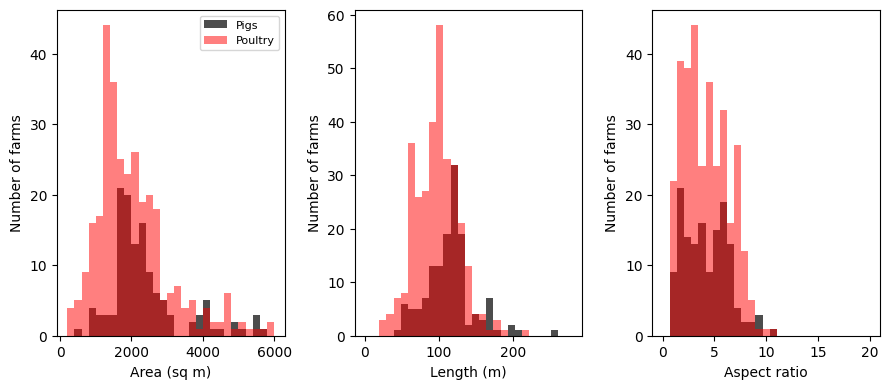

In [15]:
bins = explore.define_bins()

_, axes = plt.subplots(1, 3, figsize=(9, 4))
df = pd.DataFrame()


to_plot = max_farm_bldgs[max_farm_bldgs['countryName'] == name]
pigs = to_plot[to_plot['Description'].isin(['Pigs, 2000', 'Pigs, 750'])]
poultry = to_plot[to_plot['Description'].isin(['Poultry, 40000'])]

for col, ax in zip(["Area (sq m)", "Length (m)", "Aspect ratio"],\
                    axes):
  ax.hist(pigs[col], bins=bins[col], color='0.3',\
          histtype='stepfilled', label="Pigs")

  ax.hist(poultry[col], bins=bins[col], color='r',\
          histtype='stepfilled', alpha=0.5, label='Poultry')

  if col == "Area (sq m)":
    ax.legend(fontsize=8)
  ax.set_ylabel("Number of farms")
  ax.set_xlabel(col)

for df1, animal in zip([pigs, poultry], ["Pigs", "Poultry"]):
  df.loc[f"{name} - {animal}", "5%-ile area (sq m)"] = df1["Area (sq m)"].quantile(0.05)
  df.loc[f"{name} - {animal}", "50%-ile area (sq m)"] = df1["Area (sq m)"].quantile(0.5)
  df.loc[f"{name} - {animal}", "Max area (sq m)"] = df1["Area (sq m)"].max()

display(df)

plt.tight_layout()


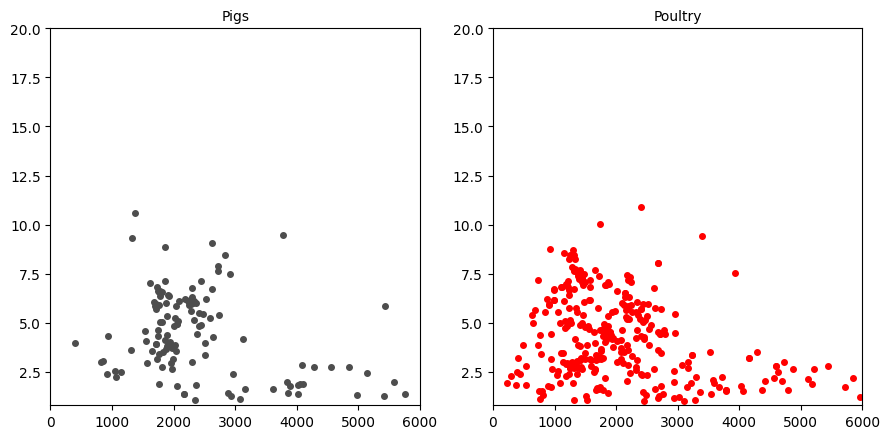

In [16]:
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(9, 4.5))

for animal, ax in zip (["Pigs", "Poultry"], [ax0, ax1]):
  to_plot = max_farm_bldgs[max_farm_bldgs['Description'].str.contains(animal)]

  if animal == "Pigs":
    color='0.3'
  else:
    color='r'
  ax.plot(to_plot["Area (sq m)"], to_plot["Aspect ratio"], color=color,\
          marker="o", ms=4, ls='')
  ax.set_title(animal, fontsize=10)
  ax.set_xlim([0, 6000])
  ax.set_ylim([0.8, 20])

plt.tight_layout()

## Visual inspection

My impressions from looking at random samples of Romanian farms are:

1. They don't appear as white and shiny as some of those in, say, Mexico. However, the buildings do tend to be in arrangements that are recognisably CAFO-like.
1. Are the low aspect ratios because of an unusually high number of buildings with slightly irregular outlines in the BFD? I didn't get the visual impression that the farm buildings are systematically more square than elsewhere.

Observations from Hungary, Lithuania, Slovakia, Bulgaria:

1.   There is quite a lot of variation in farm styles/building characteristics. Relatively few of them look like "standard CAFOs" with long, narrow, parallel, white-roofed buildings.
1. Some of them look kind of... Soviet. My impression is that industrial animal farming has been around long enough in these countries for them to have quite a lot of larger, older, non-standardized farms.
1. Some of the small aspect ratios can be explained by the building footprint dataset lumping buildings together or creating irregular building outlines
1. The coordinates appear to be pretty good; coincident with farm buildings.



In [ ]:
_ = explore.loop_over_buildings(max_farm_bldgs.sample(20))

Working on feature 1 of 20


,geometry,Parent coords,Area (sq m),countryName,Description,Length (m),Aspect ratio
271,"POLYGON ((28.52571 43.82133, 28.52563 43.82151...","POLYGON ((28.52821672173666 43.82049635787678,...",1842,Romania,"Poultry, 40000",91,4


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 2 of 20


,geometry,Parent coords,Area (sq m),countryName,Description,Length (m),Aspect ratio
272,"POLYGON ((27.25532 45.08086, 27.25517 45.08187...","POLYGON ((27.25767536592726 45.0812930592312, ...",1837,Romania,"Poultry, 40000",114,7


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 3 of 20


,geometry,Parent coords,Area (sq m),countryName,Description,Length (m),Aspect ratio
377,"POLYGON ((27.31803 47.40760, 27.31821 47.40745...",POLYGON ((27.32012937970104 47.408207259878836...,1368,Romania,"Poultry, 40000",70,3


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 4 of 20


,geometry,Parent coords,Area (sq m),countryName,Description,Length (m),Aspect ratio
243,"POLYGON ((21.77118 46.55035, 21.77145 46.55130...",POLYGON ((21.77341199151497 46.550890919333725...,1976,Romania,"Pigs, 2000",117,3


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 5 of 20


,geometry,Parent coords,Area (sq m),countryName,Description,Length (m),Aspect ratio
114,"POLYGON ((27.71411 47.13460, 27.71332 47.13464...",POLYGON ((27.714272810562683 47.13438761140993...,2765,Romania,"Poultry, 40000",63,1


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 6 of 20


,geometry,Parent coords,Area (sq m),countryName,Description,Length (m),Aspect ratio
62,"POLYGON ((24.35217 47.09954, 24.35286 47.10048...",POLYGON ((24.353908155865543 47.10025206722734...,4093,Romania,"Pigs, 2000",131,3


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 7 of 20


,geometry,Parent coords,Area (sq m),countryName,Description,Length (m),Aspect ratio
69,"POLYGON ((21.74660 46.61598, 21.74663 46.61583...",POLYGON ((21.747951278818917 46.61589738134448...,3895,Romania,"Pigs, 2000",124,2


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 8 of 20


,geometry,Parent coords,Area (sq m),countryName,Description,Length (m),Aspect ratio
423,"POLYGON ((25.89946 45.07920, 25.89959 45.07919...","POLYGON ((25.90059025010595 45.07965687332552,...",1157,Romania,"Poultry, 40000",105,9


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 9 of 20


,geometry,Parent coords,Area (sq m),countryName,Description,Length (m),Aspect ratio
306,"POLYGON ((20.56620 46.00735, 20.56600 46.00740...",POLYGON ((20.568098735722995 46.00695205687908...,1733,Romania,"Pigs, 2000",114,7


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 10 of 20


,geometry,Parent coords,Area (sq m),countryName,Description,Length (m),Aspect ratio
47,"POLYGON ((25.98762 44.84662, 25.98905 44.84631...","POLYGON ((25.98998940743269 44.84544640296596,...",4724,Romania,"Poultry, 40000",125,3


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 11 of 20


,geometry,Parent coords,Area (sq m),countryName,Description,Length (m),Aspect ratio
391,"POLYGON ((26.49765 47.81564, 26.49751 47.81570...",POLYGON ((26.499769400070946 47.81567523162962...,1310,Romania,"Poultry, 40000",107,8


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 12 of 20


,geometry,Parent coords,Area (sq m),countryName,Description,Length (m),Aspect ratio
343,"POLYGON ((23.64145 46.13208, 23.64077 46.13288...",POLYGON ((23.641916120554335 46.13261605781685...,1524,Romania,"Poultry, 40000",108,4


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 13 of 20


,geometry,Parent coords,Area (sq m),countryName,Description,Length (m),Aspect ratio
266,"POLYGON ((24.67904 45.07498, 24.67927 45.07504...",POLYGON ((24.681481246412673 45.07491937481968...,1869,Romania,"Poultry, 40000",100,5


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 14 of 20


,geometry,Parent coords,Area (sq m),countryName,Description,Length (m),Aspect ratio
330,"POLYGON ((27.03351 44.61901, 27.03364 44.61896...",POLYGON ((27.035576247867425 44.61893392590642...,1612,Romania,"Pigs, 2000",117,7


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 15 of 20


,geometry,Parent coords,Area (sq m),countryName,Description,Length (m),Aspect ratio
212,"POLYGON ((27.30038 47.48746, 27.30054 47.48700...",POLYGON ((27.303310335945874 47.48712152327800...,2175,Romania,"Pigs, 2000",65,1


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 16 of 20


,geometry,Parent coords,Area (sq m),countryName,Description,Length (m),Aspect ratio
4,"POLYGON ((25.55903 45.76308, 25.55976 45.76401...","POLYGON ((25.561339617985688 45.763558524343, ...",13014,Romania,"Poultry, 40000",145,1


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 17 of 20


,geometry,Parent coords,Area (sq m),countryName,Description,Length (m),Aspect ratio
294,"POLYGON ((26.24837 44.97909, 26.24837 44.97909...",POLYGON ((26.249322688866872 44.97801302757448...,1768,Romania,"Pigs, 2000",80,2


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 18 of 20


,geometry,Parent coords,Area (sq m),countryName,Description,Length (m),Aspect ratio
365,"POLYGON ((25.76831 45.80026, 25.76751 45.80099...",POLYGON ((25.769024848900138 45.80096100774577...,1419,Romania,"Poultry, 40000",107,5


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 19 of 20


,geometry,Parent coords,Area (sq m),countryName,Description,Length (m),Aspect ratio
77,"POLYGON ((26.00956 44.98269, 26.00966 44.98251...",POLYGON ((26.012352994327692 44.98366000779384...,3727,Romania,"Poultry, 40000",100,2


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 20 of 20


,geometry,Parent coords,Area (sq m),countryName,Description,Length (m),Aspect ratio
112,"POLYGON ((25.56171 45.75854, 25.56199 45.75848...",POLYGON ((25.562684475691622 45.75944650191953...,2789,Romania,"Poultry, 40000",136,4


Enter reject to reject, exit to exit, or any key to continue  n


## The not-farm sample

This sample seems reasonably clean. I would only have rejected a few items in the region where the not-farm buildings lie in a densely-populated part of the farm building sample. Some of them would have been defunct CAFOs. This may be worth revisiting at some point, but for now I'll use the sample as-is.

In [17]:
#%%skip

# The not-farm sample will match the Area distribution of the combined pig and
# poultry df
sampled = explore.stratified_sample(max_farm_bldgs, other_buildings, 'Area (sq m)',\
                                 bins=bins['Area (sq m)'], factor=1.2)

# Calculate length and aspect ratio for the not-farm buildings
notfarm_buildings = explore.get_dimensions(sampled, crs=crs)
print(f"We have {len(notfarm_buildings)} not-farm buildings")

# Sometimes there are a few aspect ratios that seem unrealistic, probably
# where the building footprint database has confused roads with buildings.
# Drop these.
notfarm_buildings = notfarm_buildings[notfarm_buildings['Aspect ratio'] < 20]

# This final number of not-farm buildings can be a bit less than the number of
# farm buildings, if some of the farm buildings have areas outside
# bins['Area (sq m)']
print(f"We have {len(notfarm_buildings)} not-farm buildings")

We have 521 not-farm buildings
We have 521 not-farm buildings


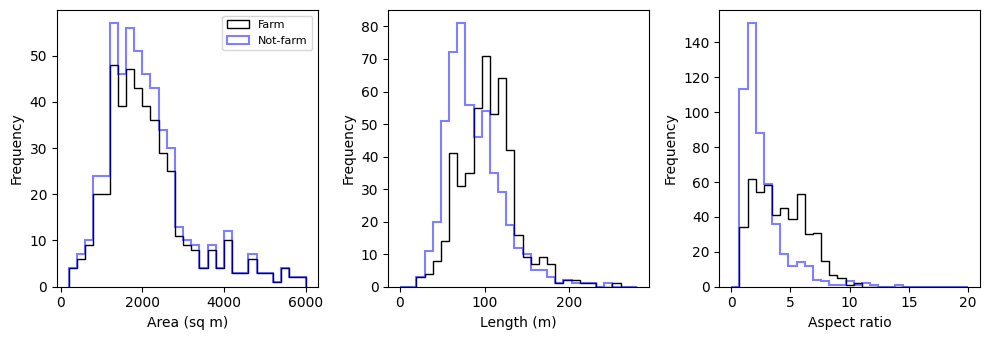

<Figure size 640x480 with 0 Axes>

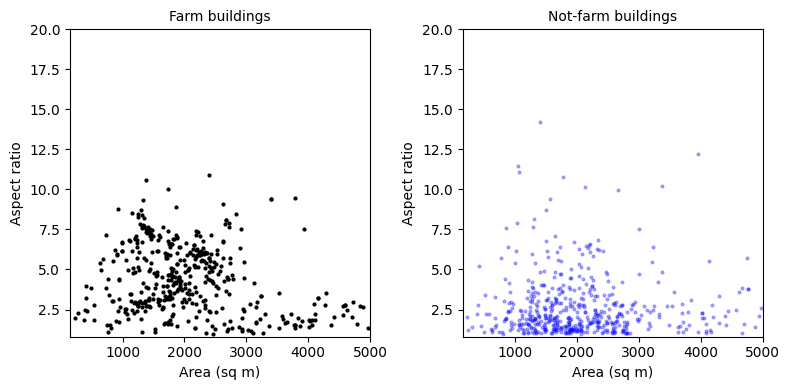

<Figure size 640x480 with 0 Axes>

In [20]:
explore.plot_notfarms(max_farm_bldgs, notfarm_buildings, bins, name)

In [24]:
to_check = notfarm_buildings[notfarm_buildings["Aspect ratio"] > 3]
to_check = to_check[to_check["Area (sq m)"] > 1000]
false_negatives = explore.loop_over_buildings(to_check.sample(30))

128
Working on feature 1 of 30


,geometry,Area (sq m),Length (m),Aspect ratio
101,"POLYGON ((24.15623 45.80249, 24.15628 45.80235...",1289,96,4


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 2 of 30


,geometry,Area (sq m),Length (m),Aspect ratio
345,"POLYGON ((27.99081 45.43600, 27.99112 45.43525...",2202,94,4


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 3 of 30


,geometry,Area (sq m),Length (m),Aspect ratio
477,"POLYGON ((26.03486 44.43874, 26.03484 44.43854...",3839,245,3


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 4 of 30


,geometry,Area (sq m),Length (m),Aspect ratio
186,"POLYGON ((28.61161 44.16028, 28.61142 44.16037...",1736,120,5


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 5 of 30


,geometry,Area (sq m),Length (m),Aspect ratio
165,"POLYGON ((24.36870 45.09583, 24.36851 45.09586...",1454,102,4


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 6 of 30


,geometry,Area (sq m),Length (m),Aspect ratio
459,"POLYGON ((26.15208 44.46457, 26.15258 44.46469...",3376,218,10


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 7 of 30


,geometry,Area (sq m),Length (m),Aspect ratio
369,"POLYGON ((20.74209 45.86577, 20.74230 45.86574...",2444,126,3


Enter reject to reject, exit to exit, or any key to continue  reject
Working on feature 8 of 30


,geometry,Area (sq m),Length (m),Aspect ratio
60,"POLYGON ((25.65274 45.80565, 25.65256 45.80569...",1193,89,3


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 9 of 30


,geometry,Area (sq m),Length (m),Aspect ratio
93,"POLYGON ((26.91207 46.57492, 26.91227 46.57488...",1318,88,5


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 10 of 30


,geometry,Area (sq m),Length (m),Aspect ratio
188,"POLYGON ((28.02681 45.42544, 28.02680 45.42554...",1731,103,4


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 11 of 30


,geometry,Area (sq m),Length (m),Aspect ratio
348,"POLYGON ((27.48473 46.06854, 27.48489 46.06849...",2327,152,3


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 12 of 30


,geometry,Area (sq m),Length (m),Aspect ratio
276,"POLYGON ((27.63270 47.14887, 27.63271 47.14906...",1896,107,5


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 13 of 30


,geometry,Area (sq m),Length (m),Aspect ratio
178,"POLYGON ((27.98599 45.44904, 27.98639 45.44832...",1632,91,5


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 14 of 30


,geometry,Area (sq m),Length (m),Aspect ratio
361,"POLYGON ((27.71957 44.76940, 27.71934 44.76941...",2207,122,7


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 15 of 30


,geometry,Area (sq m),Length (m),Aspect ratio
458,"POLYGON ((25.60284 45.76145, 25.60110 45.76187...",3227,147,6


Enter reject to reject, exit to exit, or any key to continue  reject
Working on feature 16 of 30


,geometry,Area (sq m),Length (m),Aspect ratio
487,"POLYGON ((25.62766 44.81519, 25.62593 44.81656...",4135,209,6


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 17 of 30


,geometry,Area (sq m),Length (m),Aspect ratio
380,"POLYGON ((23.68848 46.78133, 23.68812 46.78132...",2515,93,3


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 18 of 30


,geometry,Area (sq m),Length (m),Aspect ratio
503,"POLYGON ((23.25938 47.74348, 23.25970 47.74332...",4621,140,4


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 19 of 30


,geometry,Area (sq m),Length (m),Aspect ratio
303,"POLYGON ((27.99505 45.77678, 27.99482 45.77686...",2199,134,7


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 20 of 30


,geometry,Area (sq m),Length (m),Aspect ratio
51,"POLYGON ((27.56431 47.15961, 27.56467 47.15946...",1012,84,6


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 21 of 30


,geometry,Area (sq m),Length (m),Aspect ratio
378,"POLYGON ((21.53183 44.78314, 21.52993 44.78340...",2464,158,5


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 22 of 30


,geometry,Area (sq m),Length (m),Aspect ratio
364,"POLYGON ((22.31827 45.08518, 22.31833 45.08502...",2251,105,4


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 23 of 30


,geometry,Area (sq m),Length (m),Aspect ratio
87,"POLYGON ((26.20255 44.49509, 26.20353 44.49453...",1285,103,8


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 24 of 30


,geometry,Area (sq m),Length (m),Aspect ratio
300,"POLYGON ((24.46468 45.76455, 24.46523 45.76366...",2036,112,5


Enter reject to reject, exit to exit, or any key to continue  reject
Working on feature 25 of 30


,geometry,Area (sq m),Length (m),Aspect ratio
225,"POLYGON ((27.21637 44.96990, 27.21619 44.96993...",1718,128,6


Enter reject to reject, exit to exit, or any key to continue  reject
Working on feature 26 of 30


,geometry,Area (sq m),Length (m),Aspect ratio
264,"POLYGON ((21.18675 45.96304, 21.18689 45.96303...",1946,87,4


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 27 of 30


,geometry,Area (sq m),Length (m),Aspect ratio
341,"POLYGON ((23.79753 46.94194, 23.79730 46.94199...",2333,132,7


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 28 of 30


,geometry,Area (sq m),Length (m),Aspect ratio
254,"POLYGON ((26.66005 47.76467, 26.66016 47.76484...",1885,96,4


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 29 of 30


,geometry,Area (sq m),Length (m),Aspect ratio
161,"POLYGON ((26.09426 44.39712, 26.09426 44.39712...",1409,83,5


Enter reject to reject, exit to exit, or any key to continue  n
Working on feature 30 of 30


,geometry,Area (sq m),Length (m),Aspect ratio
333,"POLYGON ((28.04646 45.42882, 28.04626 45.42875...",2223,116,5


Enter reject to reject, exit to exit, or any key to continue  exit


## The final dataset

In [18]:
# Create the final dataset that will be used for training.

# -- Farm buildings
max_farm_bldgs.loc[:, "Dataset name"] = name
max_farm_bldgs.loc[max_farm_bldgs['Description'].str.contains('Pigs'), 'Farm type'] = 'Pig'
max_farm_bldgs.loc[max_farm_bldgs['Description'].str.contains('Sows'), 'Farm type'] = 'Pig'
max_farm_bldgs.loc[max_farm_bldgs['Description'].str.contains('Poultry'), 'Farm type'] = 'Poultry'
max_farm_bldgs.loc[:, "Number of animals"] = np.nan
final_farm_bldgs = explore.re_order(max_farm_bldgs)

# -- Not-farm buildings
coldict = {"Dataset name": name, "Parent coords": None,\
           "Farm type": "Non-farm", "Number of animals": np.nan}
for col, val in coldict.items():
  notfarm_buildings.loc[:, col] = val

notfarm_buildings = explore.re_order(notfarm_buildings)

print(f"There are {len(final_farm_bldgs)} farm and {len(notfarm_buildings)} not-farm locations/buildings in the final dataset")
final = pd.concat([final_farm_bldgs, notfarm_buildings])
final.to_pickle(f'/content/drive/MyDrive/CAFO_data/forTraining/interim_files/{name}_bldgs.pkl')

There are 477 farm and 521 not-farm locations/buildings in the final dataset
